设 $\Omega=[0,1]^2$，真解 $u=[x_1(1-x_1)x_2(1-x_2),0]$。$u$ 的选择确保了在边界 $\partial\Omega$ 上 $u=0$。

$$f = 
\begin{bmatrix}
35/13x_2-35/13x_2^2+10/13x_1-10/13x_1^2\\
-25/26(-1+2x_2)(-1+2x_1)
\end{bmatrix}$$
其中 $E=1$ 和 $\nu=0.3$。

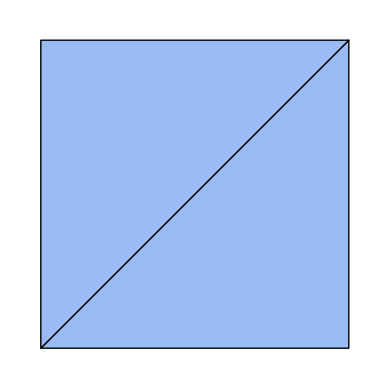

In [43]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags

import numpy as np

from fealpy.functionspace import LagrangeFESpace as Space
from fealpy.fem import LinearElasticityOperatorIntegrator
from fealpy.fem import BilinearForm
from fealpy.fem import VectorSourceIntegrator
from fealpy.fem import LinearForm
from fealpy.mesh import TriangleMesh

from linear_elasticity_model2d import BoxDomainData2d

pde = BoxDomainData2d()
mu = pde.mu
lambda_ = pde.lam
# mesh = pde.init_mesh(h=0.5)
# mesh = pde.triangle_mesh()
mesh = TriangleMesh.from_box(box=[0, 1, 0, 1], nx=1, ny=1)

import matplotlib.pyplot as plt
fig = plt.figure()
axes = fig.gca()
mesh.add_plot(axes)
plt.show()

In [44]:
p = 1
GD = 2
doforder = 'vdims'

maxit = 4
errorType = ['$|| uh - u ||_{L_2}$',
             '$|| uh - u ||_{L_\infty}$']
errorMatrix = np.zeros((2, maxit), dtype=np.float64)
NDof = np.zeros(maxit, dtype=np.int_)

for i in range(maxit):
    space = Space(mesh, p=p, doforder=doforder)
    uh = space.function(dim=GD)
    vspace = GD*(space, )
    gdof = vspace[0].number_of_global_dofs()
    vgdof = gdof * GD
    print("vgdof:", vgdof)
    ldof = vspace[0].number_of_local_dofs()
    vldof = ldof * GD
    NDof[i] = vspace[0].number_of_global_dofs()

    integrator1 = LinearElasticityOperatorIntegrator(
                lam=lambda_, mu=mu, q=3
                                                    )
    bform = BilinearForm(vspace)
    bform.add_domain_integrator(integrator1)
    KK = integrator1.assembly_cell_matrix(space=vspace)
    print("KK:", KK.shape, "\n", KK[0])
    K = bform.assembly()
    print("K:", K.shape, "\n", K.toarray())

    integrator3 = VectorSourceIntegrator(f=pde.source, q=p+5)
    lform = LinearForm(vspace)
    lform.add_domain_integrator(integrator3)
    FK = integrator3.assembly_cell_vector(space = vspace)
    print("FK:", FK.shape, "\n", FK[0])
    F = lform.assembly()
    print("F:", F.shape, "\n", F)

    dflag = vspace[0].boundary_interpolate(
        gD=pde.dirichlet, uh=uh,
        threshold=pde.is_dirichlet_boundary)
    ipoints = vspace[0].interpolation_points()
    uh[dflag] = pde.dirichlet(ipoints[dflag])
    # print("uh:", uh)
    
    F -= K@uh.flat
    F[dflag.flat] = uh.ravel()[dflag.flat]

    bdIdx = np.zeros(K.shape[0], dtype=np.int_)
    bdIdx[dflag.flat] = 1
    D0 = spdiags(1-bdIdx, 0, K.shape[0], K.shape[0])
    D1 = spdiags(bdIdx, 0, K.shape[0], K.shape[0])
    K = D0@K@D0 + D1

    uh.flat[:] = spsolve(K, F)
    u_exact = space.interpolate(pde.solution)

    # area = mesh.entity_measure(etype='cell')
    # errorMatrix[0, i] = np.sqrt(area[0] * np.sum(np.abs(uh - u_exact)**2))
    errorMatrix[0, i] = mesh.error(u=uh, v=u_exact, q=p+5, power=2)
    errorMatrix[1, i] = np.max(np.abs(uh - u_exact))
    
    if i < maxit-1:
        mesh.uniform_refine()

print("errorMatrix:\n", errorMatrix)
print("ratio:\n", errorMatrix[:, 0:-1]/errorMatrix[:, 1:])

vgdof: 8
KK: (2, 6, 6) 
 [[ 0.86538462 -0.48076923 -0.19230769  0.28846154 -0.67307692  0.19230769]
 [-0.48076923  0.86538462  0.19230769 -0.67307692  0.28846154 -0.19230769]
 [-0.19230769  0.19230769  0.19230769  0.          0.         -0.19230769]
 [ 0.28846154 -0.67307692  0.          0.67307692 -0.28846154  0.        ]
 [-0.67307692  0.28846154  0.         -0.28846154  0.67307692  0.        ]
 [ 0.19230769 -0.19230769 -0.19230769  0.          0.          0.19230769]]
K: [[ 0.86538462  0.         -0.19230769  0.19230769 -0.67307692  0.28846154
   0.         -0.48076923]
 [ 0.          0.86538462  0.28846154 -0.67307692  0.19230769 -0.19230769
  -0.48076923  0.        ]
 [-0.19230769  0.28846154  0.86538462 -0.48076923  0.          0.
  -0.67307692  0.19230769]
 [ 0.19230769 -0.67307692 -0.48076923  0.86538462  0.          0.
   0.28846154 -0.19230769]
 [-0.67307692  0.19230769  0.          0.          0.86538462 -0.48076923
  -0.19230769  0.28846154]
 [ 0.28846154 -0.19230769  0.   

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_9782/1272027598.py:7: SyntaxWarning: invalid escape sequence '\i'
  '$|| uh - u ||_{L_\infty}$']


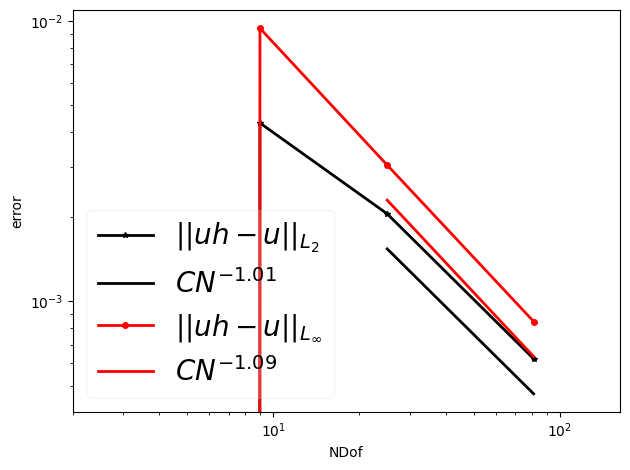

In [45]:
from fealpy.tools.show import showmultirate
import matplotlib.pyplot as plt

showmultirate(plt, 2, NDof, errorMatrix, errorType, propsize=20, lw=2, ms=4)
plt.xlabel('NDof')
plt.ylabel('error')
plt.tight_layout()
plt.show()

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

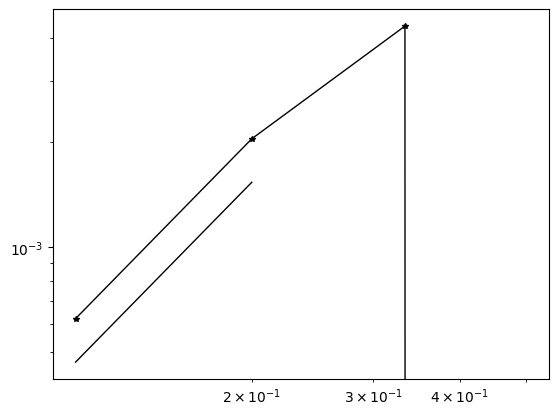

In [46]:
h = 1 / (np.power(NDof, 1/2))     
showmultirate(plt, 2, h, errorMatrix,  errorType, propsize=20)
plt.xlabel('h')
plt.ylabel('error')
plt.show()